In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import io
file_path = '/content/drive/My Drive/NCF: Philanthropic giving to Black communities in MA/Data and Documentation/Nonprofit Base Bundle and Grants Plus Bundle Data/BU_Spark_20240117.xlsx'
file_path2 = '/content/drive/My Drive/NCF: Philanthropic giving to Black communities in MA/Data and Documentation/Nonprofit Demographic Data/Demographics flat file_202401.xlsx'

# Read the Excel file into a DataFrame
df_base_bundle = pd.read_excel(file_path, sheet_name='Base_bundle')
df_grants = pd.read_excel(file_path, sheet_name='Grants')
df_organizations = pd.read_excel(file_path2, sheet_name='Organizations')

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
african_code = 'PE030000'
latin_american_code = 'PE050000'

filtered_df = df_base_bundle[df_base_bundle['pcs_population'].str.contains(african_code) | df_base_bundle['pcs_population'].str.contains(latin_american_code)]
filtered_grants_df = df_grants[df_grants['recip_population_code'].str.contains(african_code) | df_grants['recip_population_code'].str.contains(latin_american_code)]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np

In [ ]:
# Merging Data
# I want to preserve all of the grants and just include the column NTEE_code for them. However, a lot of the grants have the same NTEE code.
# UGH THIS DOESN'T WORK!!
df_grants_with_base_bundle = pd.merge(df_grants, df_base_bundle, left_on='recip_ein', right_on='ein', how='right')
filtered_df_grants_with_base_bundle = df_grants_with_base_bundle[df_grants_with_base_bundle['recip_population_code'].str.contains(african_code) | df_grants_with_base_bundle['recip_population_code'].str.contains(latin_american_code)]

print(df_grants.shape)
print(df_grants_with_base_bundle.shape)

(2473, 67)
(68114, 100)


# Key Question 2. How much funding is going toward nonprofits led by Black or LatinX individuals in Massachusetts?

### Preprocess

In [ ]:
df_org = df_organizations.copy()
df_org.index.name = 'index'
df_org.columns = [col.strip().lower() for col in df_org.columns]

# total number of eins: 63,668
df_org.rename(columns={'unnamed: 0': 'ein'}, inplace=True)
num_ein = df_org['ein'].nunique()
print("total number of unique employee ids:", num_ein)

# The total number of organizations that have received grants = 412 unique out of 2473 grants total
num_recip = df_grants['recip_ein'].nunique()
print("total number of unique employees awarded grants:", num_recip, "out of", df_grants['transaction_id'].nunique(), "total grants")

# strip of white space
df_org['ein'] = df_org['ein'].str.strip()
df_grants['recip_ein'] = df_grants['recip_ein'].str.strip()

total number of unique employee ids: 63668
total number of unique employees awarded grants: 412 out of 2473 total grants


### Merge Grants and Organizations dataframes on unique employee id number

In [ ]:
# Group grants by ein: recipient employee id
grants_by_recipient = df_grants.groupby('recip_ein').agg({'amount_usd': 'sum'}).reset_index()

# filtered org: (ein, race_leader)
filtered_organizations = df_org[['ein', 'race_leader']]

# MERGE on ein, recip_ein
df_grants_with_race_leader = pd.merge(df_org, df_grants, left_on='ein', right_on='recip_ein', how='inner')
merged_ein_count = df_grants_with_race_leader['ein'].nunique() # 119 total eins in merged
merged_race_count = df_grants_with_race_leader['race_leader'].nunique() # 9 total races in merged

# Group by race leader: lose some eins
race_leaders = df_grants_with_race_leader.groupby('race_leader')
race_counts = race_leaders.size()
total_eins = race_leaders['ein'].nunique().sum() # 113 total eins

# filtered races: African/Latinx
filtered_races = race_leaders.filter(lambda x: 'African' in x.name or 'Hispanic' in x.name)
african_latinx = filtered_races['ein'].unique()
num_african_latinx = filtered_races['ein'].nunique() # 37 African/Latinx eins
grants_african_latinx = filtered_races['amount_usd'].sum() # $11,058,130
total_grants_in_merged = (race_leaders['amount_usd'].sum()).sum() # $46,695,977

percentage_african_latinx = num_african_latinx / total_eins * 100 # 37/113
percentage_grants = grants_african_latinx / total_grants_in_merged * 100 # 11,058,130/46,695,977

print("Percentage of African/Latinx organizations out of total organizations: {:.2f}%".format(percentage_african_latinx))
print("Percentage of grants toward African/Latinx organizations out of total grants: {:.2f}%".format(percentage_grants))

Percentage of African/Latinx organizations out of total organizations: 32.74%
Percentage of grants toward African/Latinx organizations out of total grants: 23.68%


In [ ]:
ein_not_in_org = df_grants[~df_grants['recip_ein'].isin(df_org['ein'])]['recip_ein'].nunique()
percentage_not_in_org= ein_not_in_org / num_recip * 100

# Display the EINs not in the merged DataFrame
print("Percentage eins in grants but not in organizations {:.2f}%".format(percentage_not_in_org), "=", ein_not_in_org)


Percentage eins in grants but not in organizations 71.12% = 293


### Data inconsistencies

In [ ]:
no_leader_data_percent = round(df_org['race_leader'].isnull().sum() / len(df_org) * 100,2)
print(no_leader_data_percent, "% of organizations have no race_leader data")

percentage = 100 - (merged_ein_count / num_recip) * 100 # 293 out of 412 were lost
print("{:.2f}% of organizations that received grants were lost during the merge".format(percentage))

percentage_lost = ((merged_ein_count - total_eins) / merged_ein_count) * 100
print("{:.2f}% of additional data was lost during grouping because of missing race leader values: ".format(percentage_lost))

# total_grants = all grants received by organization
total_grants = grants_by_recipient['amount_usd'].sum()

10.26 % of organizations have no race_leader data
71.12% of organizations that received grants were lost during the merge
5.04% of additional data was lost during grouping because of missing race leader values: 


### Answer Question:

In [ ]:
percentage = grants_african_latinx / total_grants_in_merged
percentage_str = "{:.2f}%".format(percentage * 100)

print(percentage_str, "of funding is going towards nonprofits led by Black or LatinX individuals in MA = ", grants_african_latinx)

23.68% of funding is going towards nonprofits led by Black or LatinX individuals in MA =  11058130


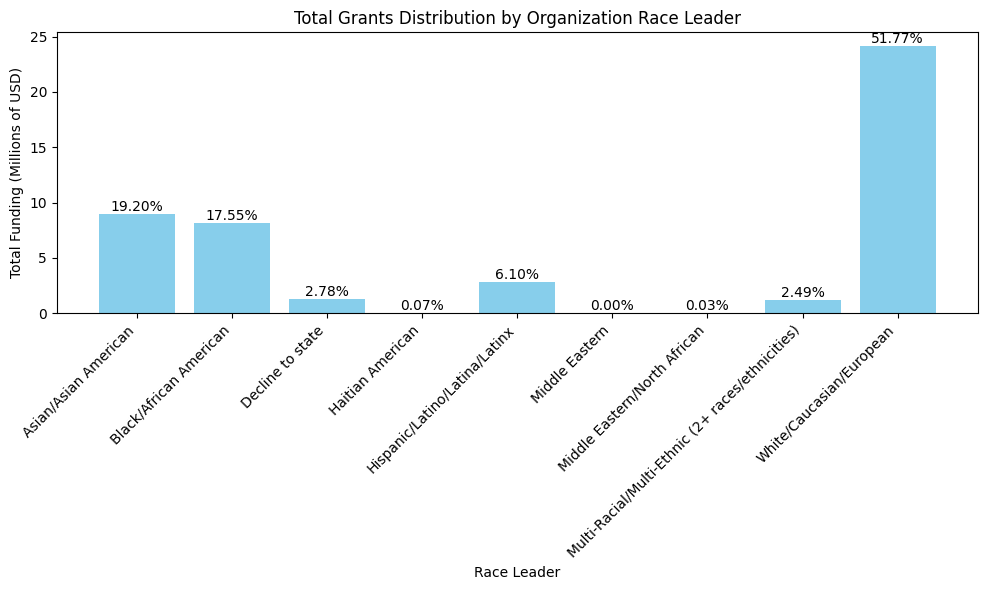

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

total_amount_by_race_leader = df_grants_with_race_leader.groupby('race_leader')['amount_usd'].sum()
total_grants_in_merged = total_amount_by_race_leader.sum()
percentage_by_race_leader = (total_amount_by_race_leader / total_grants_in_merged) * 100

# Plot bar chart of grants received by race leader using percentage
plt.figure(figsize=(10, 6))
bars = plt.bar(percentage_by_race_leader.index, total_amount_by_race_leader.values / 1e6, color='skyblue')  # Divide by 1e6 to convert to millions
plt.xlabel('Race Leader')
plt.ylabel('Total Funding (Millions of USD)')
plt.title('Total Grants Distribution by Organization Race Leader')
plt.xticks(rotation=45, ha='right')

# Adding percentage labels on top of bars
for bar, percentage in zip(bars, percentage_by_race_leader.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), '{:.2f}%'.format(percentage),
             ha='center', va='bottom')

# Formatting y-axis to display exact amounts in millions
def millions_formatter(x, pos):
    return '{:,.0f}'.format(x)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.tight_layout()
plt.show()


In [ ]:
# Redo this step
african_code = 'PE030000'
latin_american_code = 'PE050000'

filtered_df = df_base_bundle[df_base_bundle['pcs_population'].str.contains(african_code) | df_base_bundle['pcs_population'].str.contains(latin_american_code)]
filtered_grants_df = df_grants[df_grants['recip_population_code'].str.contains(african_code) | df_grants['recip_population_code'].str.contains(latin_american_code)]
print("Total number of eins that aim for the target community who have also been given grants", filtered_grants_df['recip_ein'].nunique()) # 127

Total number of eins that aim for the target community who have also been given grants 127


### Each race leader leads n organizations. How many of those organizations are targetting African/LatinX individuals?

In [ ]:
recip_african_latinx = filtered_grants_df.groupby('recip_ein').agg({'amount_usd': 'sum'}).reset_index()

# Find the race leaders of those organizations'
merged_recip_african_latinx = pd.merge(df_org, recip_african_latinx, left_on='ein', right_on='recip_ein', how='inner')
print("Total number of organizations that aim for the target community who have also been given grants", merged_recip_african_latinx['org_name'].nunique()) # 38

# This makes sense because this is all the orgs that target the african/latinx communities which could be more than the orgs that are led by the african/latinx communities (37)

# # Group the grants given to those organizations by race leader
amount_by_race_leader = merged_recip_african_latinx.groupby('race_leader')['amount_usd'].sum()
amount_by_race_leader = amount_by_race_leader.reindex(total_amount_by_race_leader.index, fill_value=0)

# # Find out what percentage of the grants given to organizations led by race leaders also target African/LatinX individuals
percentage = (amount_by_race_leader / total_amount_by_race_leader) * 100
print(percentage)

Total number of organizations that aim for the target community who have also been given grants 38
race_leader
Asian/Asian American                                35.931278
Black/African American                              74.170871
Decline to state                                     0.021170
Haitian American                                     0.000000
Hispanic/Latino/Latina/Latinx                       37.375220
Middle Eastern                                       0.000000
Middle Eastern/North African                         0.000000
Multi-Racial/Multi-Ethnic (2+ races/ethnicities)    40.998715
White/Caucasian/European                            27.096724
Name: amount_usd, dtype: float64


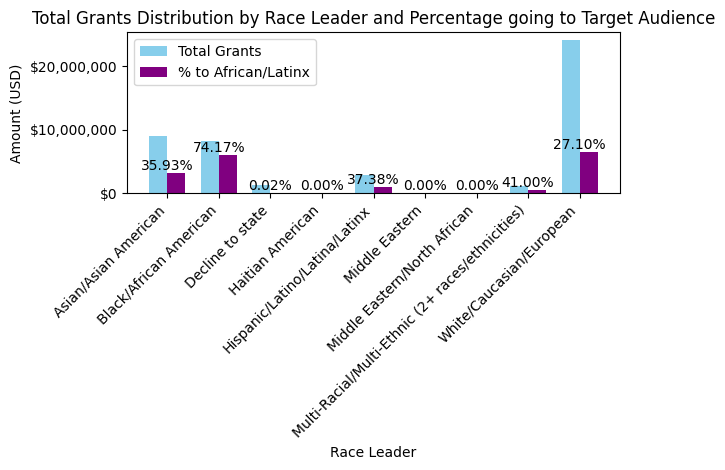

In [ ]:
import numpy as np

# Each race leader leads n organizations. How many of those organizations are targetting African/LatinX individuals?

bar_width = 0.35
num_race_leaders = len(total_amount_by_race_leader)
positions = np.arange(num_race_leaders)
plt.bar(positions, total_amount_by_race_leader, bar_width, color='skyblue', label='Total Grants')
plt.bar(positions + bar_width, amount_by_race_leader, bar_width, color='purple', label='% to African/Latinx')

# Find the % of organizations that are targetting African/LatinX individuals
for i, perc in enumerate(percentage):
    plt.text(positions[i] + bar_width / 2, amount_by_race_leader[i], f'{perc:.2f}%', ha='center', va='bottom')

plt.xticks(positions + bar_width / 2, total_amount_by_race_leader.index, rotation=45, ha='right')

plt.title('Total Grants Distribution by Race Leader and Percentage going to Target Audience')
plt.xlabel('Race Leader')
plt.ylabel('Amount (USD)')
plt.legend()

def format_func(value, tick_number):
    return f"${value:,.0f}"

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))


# Show the graph
plt.tight_layout()
plt.show()

# Extension Question 1a: Filter out education, hospitals, and religious institutions

In [ ]:
hospitals = df_base_bundle[df_base_bundle['organization_name'].str.contains('hospital', case=False, na=False)]
unique_hospital_orgs = hospitals['organization_name'].unique()
print(len(unique_hospital_orgs))

hospitals = filtered_df[filtered_df['organization_name'].str.contains('hospital', case=False, na=False)]
unique_hospital_orgs = hospitals['organization_name'].unique()
print(len(unique_hospital_orgs))

98
0


In [ ]:
churches = df_base_bundle[df_base_bundle['organization_name'].str.contains('church', case=False, na=False)]
unique_church_orgs = churches['organization_name'].unique()
print(len(unique_church_orgs))

churches = filtered_df[filtered_df['organization_name'].str.contains('church', case=False, na=False)]
unique_church_orgs = churches['organization_name'].unique()
print(len(unique_church_orgs))

86
0


In [ ]:
NTEE_health_orgs = df_base_bundle[df_base_bundle['ntee_code'].str.contains('E', case=False, na=False)]
filtered_NTEE_health_orgs = filtered_df[filtered_df['ntee_code'].str.contains('E', case=False, na=False)]
print("There are", len(NTEE_health_orgs), "organizations classified under Health Care")
print("There are", len(filtered_NTEE_health_orgs), "organizations for the Black/LatinX commnunity classified under Health Care")

NTEE_religious_orgs = df_base_bundle[df_base_bundle['ntee_code'].str.contains('X', case=False, na=False)]
filtered_NTEE_religious_orgs = filtered_df[filtered_df['ntee_code'].str.contains('X', case=False, na=False)]
print("There are", len(NTEE_religious_orgs), "organizations classified under Religious Orgs")
print("There are", len(filtered_NTEE_religious_orgs), "organizations for the Black/LatinX commnunity classified under Religious Orgs")

NTEE_higher_ed_orgs = df_base_bundle[df_base_bundle['ntee_code'].str.contains('B', case=False, na=False)]
filtered_NTEE_higher_ed_orgs = filtered_df[filtered_df['ntee_code'].str.contains('B', case=False, na=False)]
print("There are", len(NTEE_higher_ed_orgs), "organizations classified under Education")
print("There are", len(filtered_NTEE_higher_ed_orgs), "organizations for the Black/LatinX commnunity classified under Education")

There are 2731 organizations classified under Health Care
There are 10 organizations for the Black/LatinX commnunity classified under Health Care
There are 1360 organizations classified under Religious Orgs
There are 0 organizations for the Black/LatinX commnunity classified under Religious Orgs
There are 10143 organizations classified under Education
There are 70 organizations for the Black/LatinX commnunity classified under Education


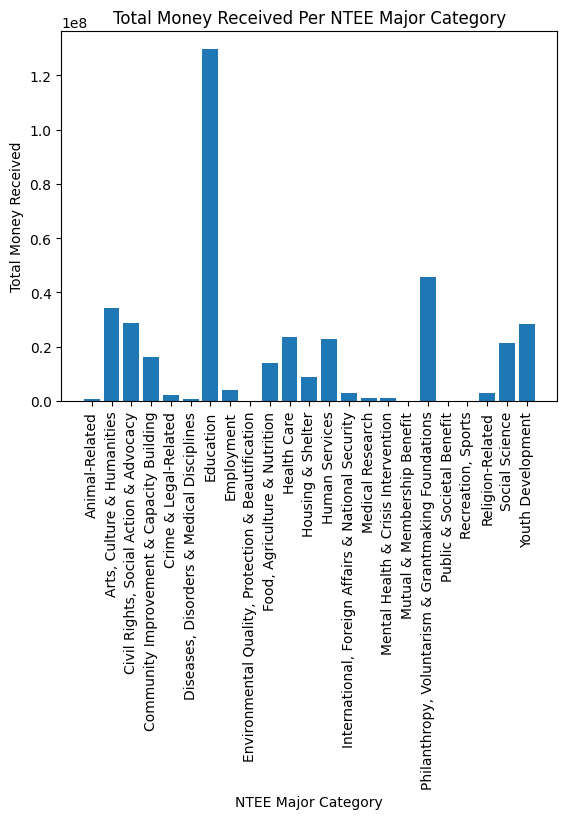

In [ ]:
df_grants_with_base_bundle_copy = df_grants_with_base_bundle.copy()
df_grants_with_base_bundle_copy['ntee_code_category'] = df_grants_with_base_bundle_copy['ntee_code'].apply(lambda x: x[0] if isinstance(x, str) else None)
ntee_code_catogories = {
    'A': 'Arts, Culture & Humanities',
    'B': 'Education',
    'C': 'Environmental Quality, Protection & Beautification',
    'D': 'Animal-Related',
    'E': 'Health Care',
    'F': 'Mental Health & Crisis Intervention',
    'G': 'Diseases, Disorders & Medical Disciplines',
    'H': 'Medical Research',
    'I': 'Crime & Legal-Related',
    'J': 'Employment',
    'K': 'Food, Agriculture & Nutrition',
    'L': 'Housing & Shelter',
    'M': 'Public Safety, Disaster Preparedness & Relief',
    'N': 'Recreation, Sports',
    'O': 'Youth Development',
    'P': 'Human Services',
    'Q': 'International, Foreign Affairs & National Security',
    'R': 'Civil Rights, Social Action & Advocacy',
    'S': 'Community Improvement & Capacity Building',
    'T': 'Philanthropy, Voluntarism & Grantmaking Foundations',
    'U': 'Science & Technology',
    'V': 'Social Science',
    'W': 'Public & Societal Benefit',
    'X': 'Religion-Related',
    'Y': 'Mutual & Membership Benefit',
    'Z': 'Unknown'
}

df_grants_with_base_bundle_copy['ntee_code_category'] = df_grants_with_base_bundle_copy['ntee_code_category'].apply(lambda x: ntee_code_catogories[x] if x in ntee_code_catogories else None)
ntee_category_funding = df_grants_with_base_bundle_copy.groupby('ntee_code_category').agg({'amount_usd': 'sum'}).reset_index()

plt.bar(ntee_category_funding['ntee_code_category'], ntee_category_funding['amount_usd'])
plt.xticks(rotation=90)
plt.title('Total Money Received Per NTEE Major Category')
plt.xlabel('NTEE Major Category')
plt.ylabel('Total Money Received')
plt.show()



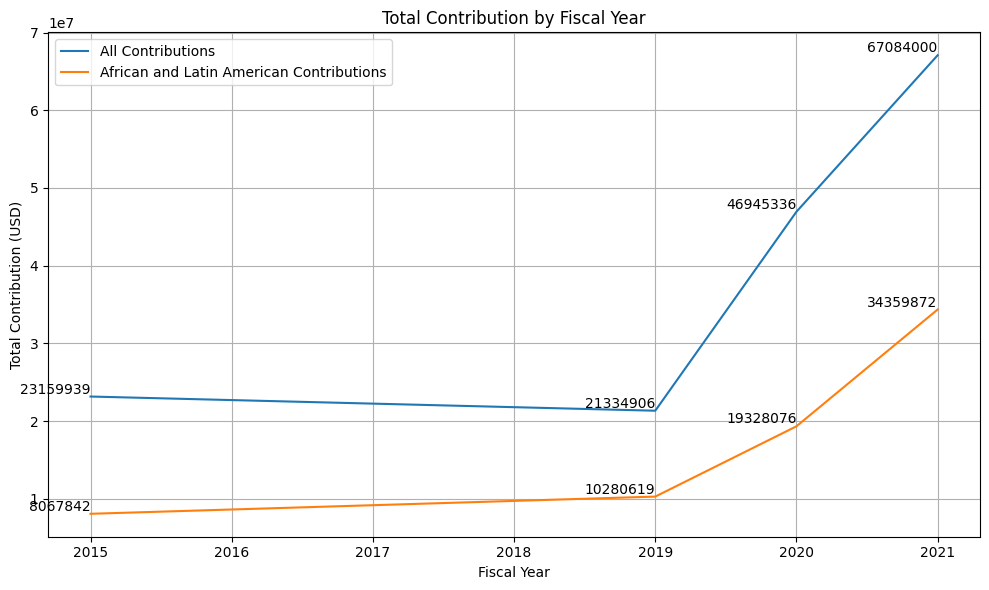

In [ ]:
# finding the comparison for amount of grants towards african/latinx vs total contributions
total_amount_by_year = df_grants.groupby('fiscal_year')['amount_usd'].sum()
yearly_contrib = filtered_grants_df.groupby('fiscal_year')['amount_usd'].sum()

# Plotting the graph of the amounts
plt.figure(figsize=(10, 6))
plt.plot(total_amount_by_year.index, total_amount_by_year.values, label='All Contributions')
plt.plot(yearly_contrib.index, yearly_contrib.values, label='African and Latin American Contributions')

for i, txt in enumerate(total_amount_by_year.values):
    plt.text(total_amount_by_year.index[i], txt, f'{txt:.0f}', ha='right', va='bottom')

for i, txt in enumerate(yearly_contrib.values):
    plt.text(yearly_contrib.index[i], txt, f'{txt:.0f}', ha='right', va='bottom')

plt.xlabel('Fiscal Year')
plt.ylabel('Total Contribution (USD)')
plt.title('Total Contribution by Fiscal Year')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


(6499, 101)


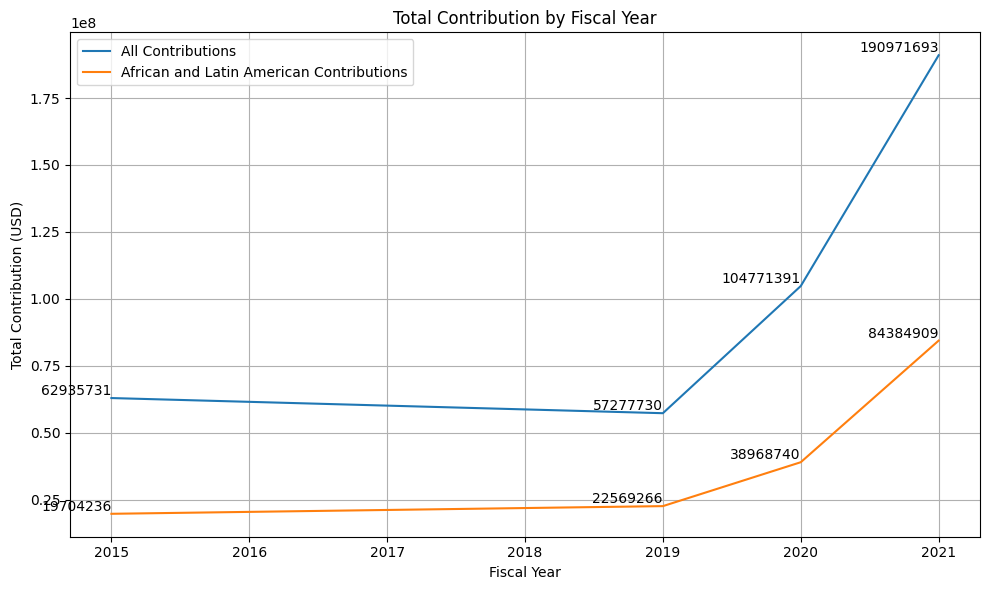

In [ ]:
# this removes Health Care, Education, and Religious institutions from the dataset so that we can focus on trends we may have missed
# ok this does not work... the merging created more rows than before so now there's like way more money than there should be
merged_df = df_grants_with_base_bundle_copy
# merged_df_reduced = merged_df[~((merged_df['ntee_code_category'].str.contains('E')) | (merged_df['ntee_code_category'].str.contains('B')) | (merged_df['ntee_code_category'].str.contains('X')))]
print(merged_df.shape)

filtered_merged_df_reduced = merged_df[merged_df['pcs_population'].str.contains(african_code) | merged_df['pcs_population'].str.contains(latin_american_code)]

# Re-Run some major graphs after removing these categories
total_amount_by_year = merged_df.groupby('fiscal_year')['amount_usd'].sum()
yearly_contrib = filtered_merged_df_reduced.groupby('fiscal_year')['amount_usd'].sum()

# Plotting the graph of the amounts
plt.figure(figsize=(10, 6))
plt.plot(total_amount_by_year.index, total_amount_by_year.values, label='All Contributions')
plt.plot(yearly_contrib.index, yearly_contrib.values, label='African and Latin American Contributions')

for i, txt in enumerate(total_amount_by_year.values):
    plt.text(total_amount_by_year.index[i], txt, f'{txt:.0f}', ha='right', va='bottom')

for i, txt in enumerate(yearly_contrib.values):
    plt.text(yearly_contrib.index[i], txt, f'{txt:.0f}', ha='right', va='bottom')

plt.xlabel('Fiscal Year')
plt.ylabel('Total Contribution (USD)')
plt.title('Total Contribution by Fiscal Year')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


There are 140 subject populations in our organization database.
12 of them are related to race.


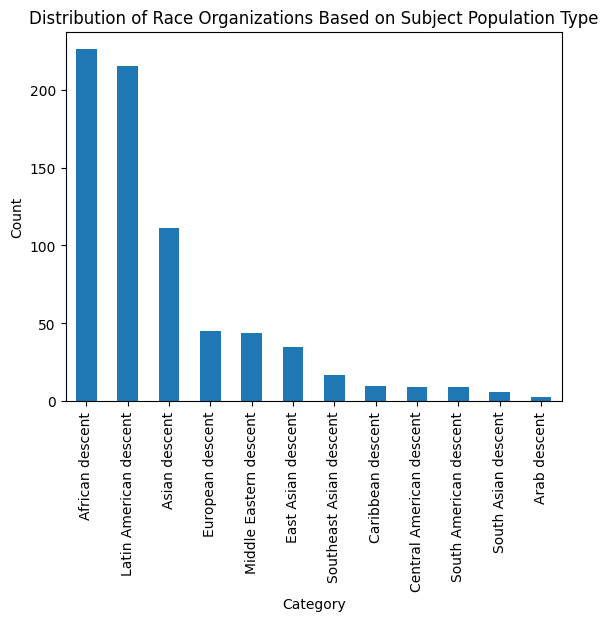

In [ ]:
import warnings
warnings.filterwarnings('ignore')

df_base_bundle_expanded = df_base_bundle.assign(pcs_population=df_base_bundle['pcs_population'].str.split(';')).explode('pcs_population')
df_base_bundle_expanded['pcs_population'] = df_base_bundle_expanded['pcs_population'].apply(lambda x: x.strip() if isinstance(x, str) else x)
# populations_counts = df_base_bundle_expanded['pcs_population'].value_counts()
# populations_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
# plt.title('Distribution of Categories')
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.show()
# plt.clf()

filtered_race_populations = df_base_bundle_expanded[df_base_bundle_expanded['pcs_population'].str.contains('People of', na=False)]
filtered_race_populations['pcs_population'] = filtered_race_populations['pcs_population'].apply(lambda x: ' '.join(x.split()[3:len(x)-1]) if isinstance(x, str) else x)
filtered_race_populations_counts = filtered_race_populations['pcs_population'].value_counts()
print("There are", len(df_base_bundle_expanded['pcs_population'].value_counts()),"subject populations in our organization database.")
print(len(filtered_race_populations_counts), "of them are related to race.")

filtered_race_populations_counts.plot(kind='bar')
plt.title('Distribution of Race Organizations Based on Subject Population Type')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

# filtered_race_populations_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
# plt.title('Distribution of Categories')
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.show()

## Top Grantmakers for racial justice programs ##

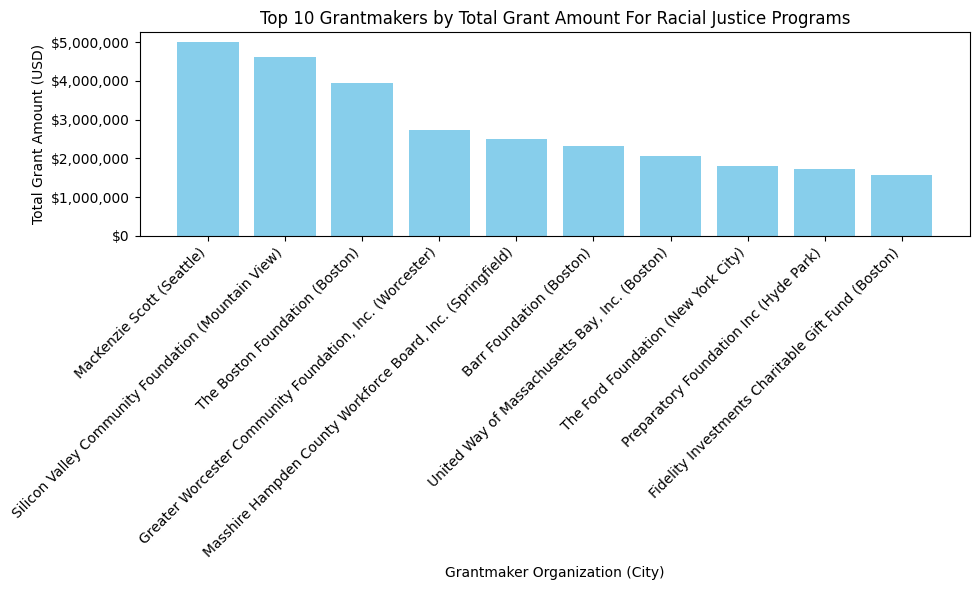

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assuming your dataset is loaded into a DataFrame called 'df'

# Group by grantmaker_id and aggregate other columns while summing the grant amounts
grantmaker_summary = filtered_grants_df.groupby('grantmaker_id').agg({
    'gm_name': 'first',  # Grantmaker name
    'gm_city': 'first',  # Grantmaker city
    'gm_state': 'first',  # Grantmaker state
    # Add other columns you want to keep here
    'amount_usd': 'sum'  # Total grant amount
}).reset_index()  # Reset the index to make the grantmaker_id a regular column

# Combine 'gm_name' and 'gm_city' into a single string
grantmaker_summary['Grantmaker'] = grantmaker_summary['gm_name'] + ' (' + grantmaker_summary['gm_city'] + ')'

# Sort the DataFrame by total grant amount in descending order
grantmaker_summary_sorted = grantmaker_summary.sort_values(by='amount_usd', ascending=False)

# Get the top 10 grantmakers
top_10_grantmakers = grantmaker_summary_sorted.head(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_10_grantmakers['Grantmaker'], top_10_grantmakers['amount_usd'], color='skyblue')
plt.xlabel('Grantmaker Organization (City)')
plt.ylabel('Total Grant Amount (USD)')
plt.title('Top 10 Grantmakers by Total Grant Amount For Racial Justice Programs')
plt.xticks(rotation=45, ha='right')
# Formatting y-axis to display ticks in tens of millions
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()


## Top Cities of Grantmakers ##

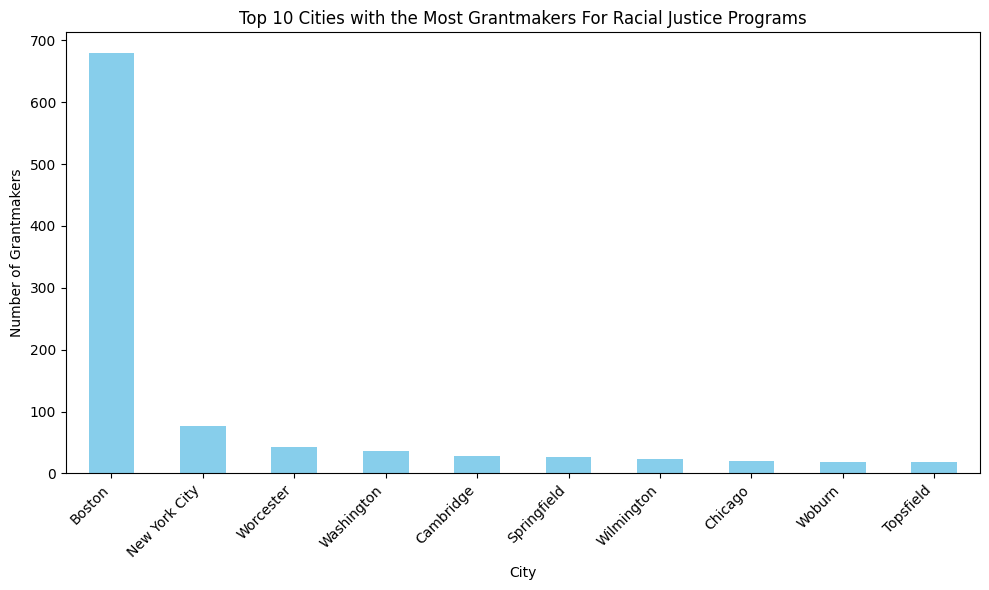

In [ ]:
# Group by city and count the number of grantmakers in each city
city_counts = filtered_grants_df.groupby('gm_city').size().sort_values(ascending=False)

# Get the top 10 cities
top_10_cities = city_counts.head(10)

# Plotting
plt.figure(figsize=(10, 6))
top_10_cities.plot(kind='bar', color='skyblue')
plt.xlabel('City')
plt.ylabel('Number of Grantmakers')
plt.title('Top 10 Cities with the Most Grantmakers For Racial Justice Programs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Top Grantmakers for racial justice programs ##

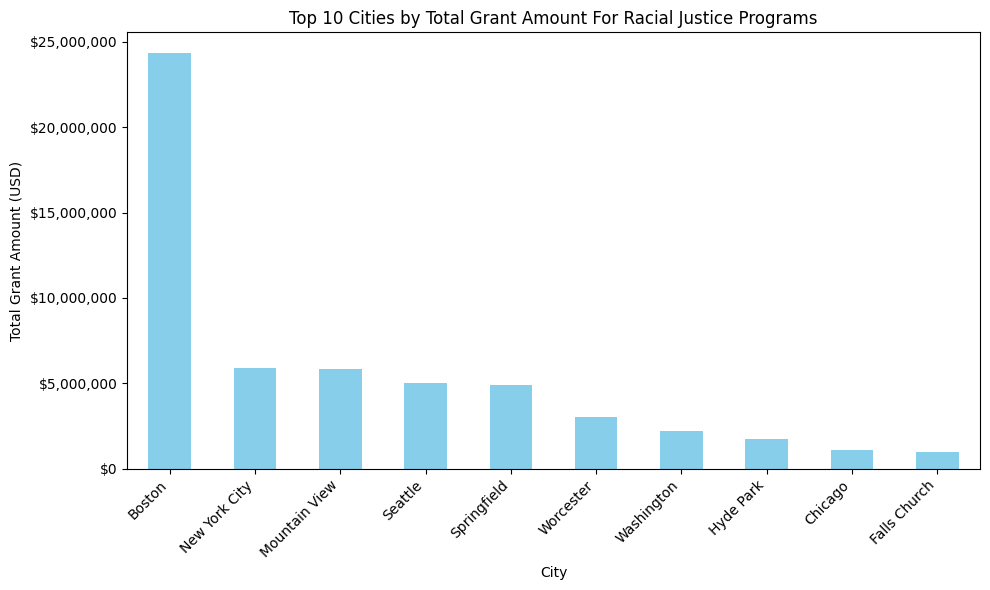

In [ ]:
# Group by city and sum the grant amounts
city_grant_amounts = filtered_grants_df.groupby('gm_city')['amount_usd'].sum().sort_values(ascending=False)

# Get the top 10 cities by total grant amount
top_10_cities = city_grant_amounts.head(10)

# Plotting
plt.figure(figsize=(10, 6))
top_10_cities.plot(kind='bar', color='skyblue')
plt.xlabel('City')
plt.ylabel('Total Grant Amount (USD)')
plt.title('Top 10 Cities by Total Grant Amount For Racial Justice Programs')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


[["NAME","P2_001N","P2_002N","P2_005N","P2_006N","P2_007N","P2_008N","P2_009N","P2_010N","state"],
["Massachusetts","7029917","887685","4748897","457055","9387","504900","1607","92108","25"]]


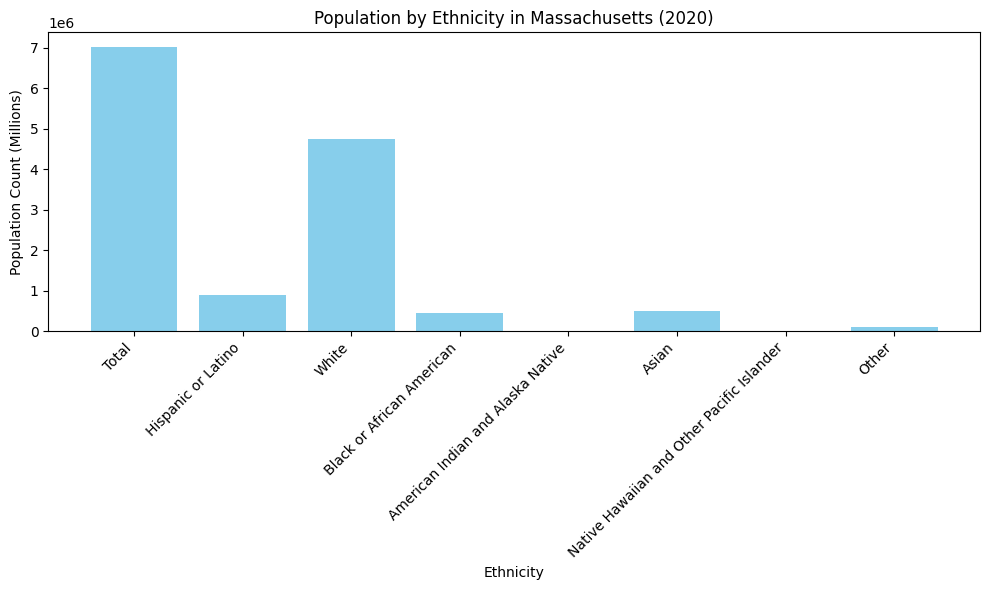

In [ ]:
# Massachussetes Demographic
import requests
import matplotlib.pyplot as plt

# set variables
year='2020'
dsource='dec' # which survey are we interested in? -> decennial
dname='pl' # a dataset within a survey, pl -> redistricting data
state='25' # state code -> Massachusetts

cols = 'NAME,P2_001N,P2_002N,P2_005N,P2_006N,P2_007N,P2_008N,P2_009N,P2_010N'

base_url = f"https://api.census.gov/data/{year}/{dsource}/{dname}"
census_url = f"{base_url}?get={cols}&for=state:{state}"
response = requests.get(census_url)

print(response.text)
# Parse the response
data = response.json()

# Extracting column names and data
columns = data[0]
values = data[1]

# Creating labels and values for the plot
ethnicities = ['Total', 'Hispanic or Latino','White', 'Black or African American', 'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and Other Pacific Islander','Other']
population_counts = [int(value) for value in values[1:]]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(ethnicities, population_counts[:-1], color='skyblue')
plt.title('Population by Ethnicity in Massachusetts (2020)')
plt.xlabel('Ethnicity')
plt.ylabel('Population Count (Millions)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()